In [1]:
from diffusers.utils import load_image

background_image = load_image(
  "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/landscape.png"
)

openpose_image = load_image(
  "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

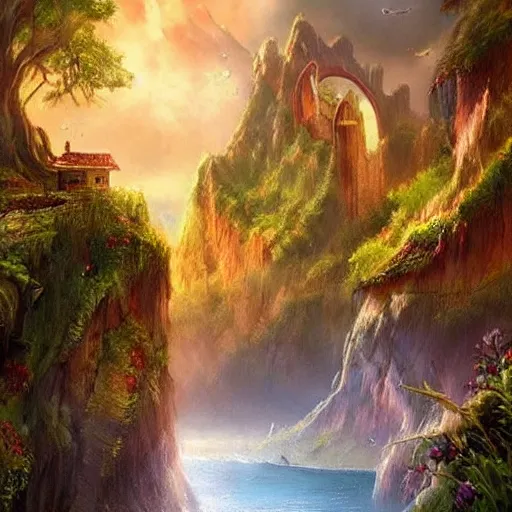

In [2]:
background_image

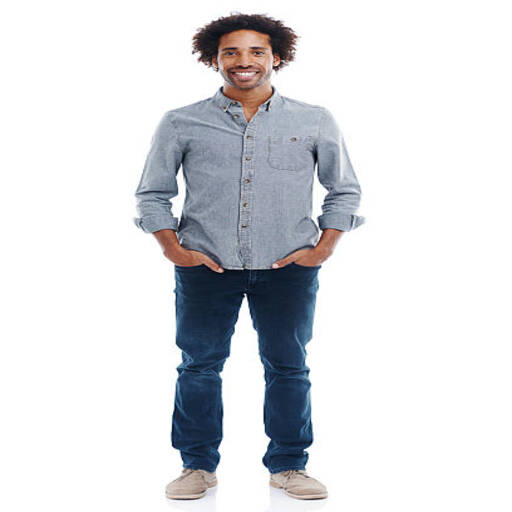

In [3]:
openpose_image

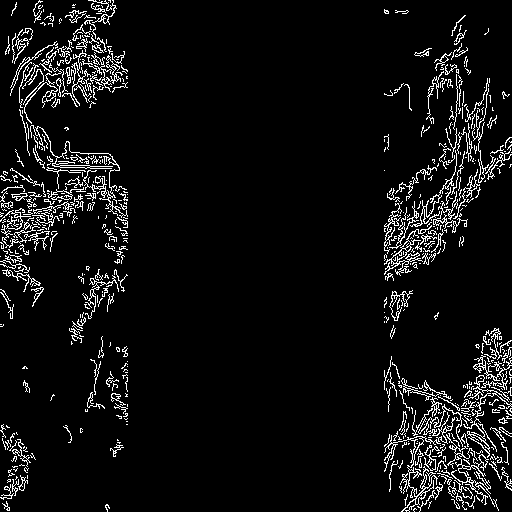

In [4]:
import cv2
from PIL import Image
import numpy as np


def to_canny(image, low_threshold=100, high_threshold=200):
  image = cv2.Canny(image, low_threshold, high_threshold)
  image = image[:, :, None]
  image = np.concatenate([image, image, image], axis=2)

  zero_start = image.shape[1] // 4
  zero_end = zero_start + image.shape[1] // 2
  image[:, zero_start:zero_end] = 0

  canny_image = Image.fromarray(image)
  return canny_image


background_canny = to_canny(np.array(background_image))
background_canny

In [5]:
from controlnet_aux import OpenposeDetector

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose

/home/kiddos/.pyenv/versions/3.10.12/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [6]:
pose_image = openpose(openpose_image)

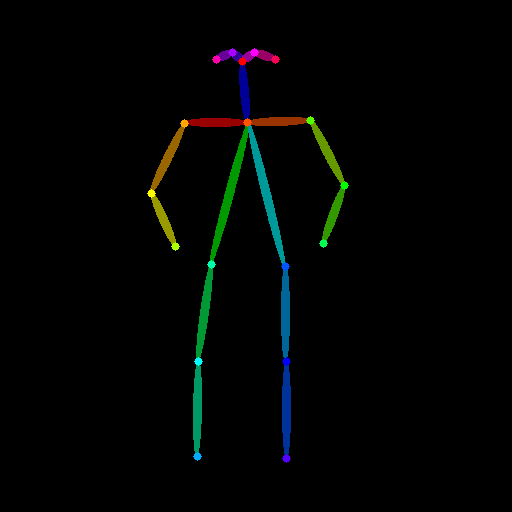

In [7]:
pose_image

In [8]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = [
  ControlNetModel.from_pretrained('lllyasviel/sd-controlnet-openpose', torch_dtype=torch.float16),
  ControlNetModel.from_pretrained('lllyasviel/sd-controlnet-canny', torch_dtype=torch.float16),
]

model_id = 'runwayml/stable-diffusion-v1-5'
pipe = StableDiffusionControlNetPipeline.from_pretrained(
  model_id,
  controlnet=controlnet,
  torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/60 [00:00<?, ?it/s]

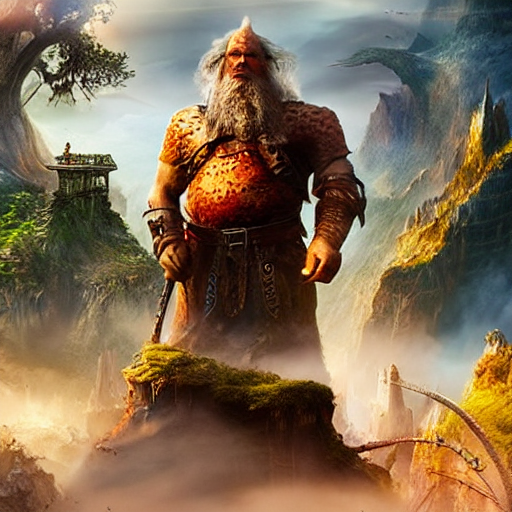

In [9]:
prompt = 'a giant standing in a fantasy landscape, best quality'
negative_prompt = 'monochrome, lowres, bad anatomy, worst quality, low quality'

generator = torch.Generator(device='cpu').manual_seed(666666)
images = [pose_image, background_canny]

image = pipe(
  prompt,
  images,
  num_inference_steps=60,
  generator=generator,
  negative_prompt=negative_prompt,
  controlnet_conditioning_scale=[1.0, 0.8],
).images[0]

image